# Verify `cosmopower-jax` output against `camb` output

We verify the linear matter power spectrum $P_{\mathrm{L}}(k)$ output by `cosmopower-jax` against the `camb` counterpart.

## Import modules

In [375]:
import sys, platform, os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "STIXGeneral",
    "font.sans-serif": "Computer Modern",
    "font.size": 22})

import jax.numpy as np

import jax
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ
jax.config.update('jax_enable_x64', True)

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.6.0 installed at /Users/nguyenmn/miniconda3/envs/sbi_pytorch_osx-arm64-py310forge/lib/python3.10/site-packages/camb


## Define cosmology

We adopt the cosmology in [Planck 2018 results. VI. Cosmological parameters](https://arxiv.org/abs/1807.06209), specifically the `TT,TE,EE+lowE+lensing+BAO` column in their Table 2.

In [376]:
# Relevant parameters for `cosmopower-jax` - LCDM
## P_lin parameters
h = np.array([0.6766,])
ombh2 = 0.02242*np.ones_like(h)
omch2 = 0.11933*np.ones_like(h)
n_s = 0.9665*np.ones_like(h)
A_s = 3.047*np.ones_like(h) # ln(10^{10}A_s)
## P_nonlin parameters
A_b = 3.13*np.ones_like(h)
eta_b = 0.603*np.ones_like(h)
logT_AGN = 7.8*np.ones_like(h)

# LCDM extensions
m_ncdm=0.06*np.ones_like(h)
w_0=-1.*np.ones_like(h)
w_a=0.**np.ones_like(h)

# Redshift
z = 0.0*np.ones_like(h)

## Define model and emulate or compute $P_\mathrm{L}(k)$ with `cosmopower-jax` or `camb`.

Get $P_{\mathrm{L}}(k,z)$ from `cosmopower-jax`. Below, we define two models: (1) default model in `cosmopower-jax` and (2) a custom model load from either `cosmopower-organization/jense_2024_emulators/jense_2023_camb_lcdm/networks` or `cosmopower-organization/mnu`.

(1) assumes massless neutrinos and $\tau=0.079$ so not really useful if we want to assume PL18 as the fiducial cosmology; (2) assumes PL18 cosmology with one massive neutrino $m_\nu=0.06\,eV$.

In [377]:
# Default model

## Define model
default_emulator = CPJ(probe='mpk_lin')
print(default_emulator.parameters)
## Define model parameters
default_params = []
default_params_dict = {'omega_b': ombh2, 'omega_cdm':omch2,'h': h,\
                       'n_s': n_s,'ln10^{10}A_s': A_s,\
                       'z': z,}
for item in cosmo_params_dict.items():
    default_params.append(item[1]) # extract the actual parameters from the dictionary
default_params = np.array(default_params).T

# Custom model
model_path='../cosmology/jense2024/jense_2023_camb_lcdm/networks/jense_2023_camb_lcdm_Pk_lin.npz'
custom_emulator = CPJ(probe='custom_log', filepath=model_path)
print(custom_emulator.parameters)

## Define model parameters
custom_params = []
custom_params_dict = {'ombh2': ombh2, 'omch2':omch2,\
                      'logA': A_s,'ns': n_s,\
                      'h': h,\
                      'z': z,
                     'A_b': A_b, 'eta_b': eta_b, 'logT_AGN': logT_AGN,} # P_nonlin parameters
for item in custom_params_dict.items():
    custom_params.append(item[1]) # extract the actual parameters from the dictionary
custom_params = np.array(custom_params).T

# Emulate
default_k = default_emulator.modes
default_pk = default_emulator.predict(default_params_dict)

custom_k = custom_emulator.modes
custom_pk = custom_emulator.predict(custom_params_dict)

['omega_b', 'omega_cdm', 'h', 'n_s', 'ln10^{10}A_s', 'z']
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, in case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
['ombh2' 'omch2' 'logA' 'ns' 'h' 'z' 'A_b' 'eta_b' 'logT_AGN']


In [378]:
# Default model outputs `emulator.modes=k` [Mpc^{-1}] and `emulator.predict()=pk` [Mpc^{-3}]
#cosmopower_pk=default_pk

# Custom model
## Some custom model outputs `emulator.predict()=[2*pi/ls(ls+1)]*pk` instead of pk where `ls=emulator.modes`
# ndspl = 10
# custom_k = np.geomspace(1e-4,50.,5000)[::ndspl]
# ls = custom_emulator.modes
# dls = ls*(ls+1.)/2./np.pi
# cosmopower_pk = ((dls)**-1)*(custom_pk)

## Jense et al. 2024 custom models seem to output `emulator.modes=k` [Mpc^{-1}] and `emulator.predict()=pk` [h^3Mpc^{-3}]
cosmopower_pk=custom_pk

Get $P_{\mathrm{L}}(k,z)$ from `camb`.

In [379]:
# Relevant parameter for `camb` - LCDM
H0=67.66
h=H0/100.
ombh2=0.02242
omch2=0.11933
n_s = 0.9665
A_s = 3.047
num_massive_neutrinos=1
mnu=0.06
tau=0.054
omk=0.0
camb_lmax=5000
camb_minkh=custom_k.min()/h
camb_maxkh=custom_k.max()/h

camb_pars = camb.set_params(H0=H0, ombh2=ombh2, omch2=omch2, \
                            mnu=mnu, num_massive_neutrinos=num_massive_neutrinos, neutrino_hierarchy='degenerate', \
                            omk=omk, tau=tau,  
                            As=np.exp(A_s)*1E-10, ns=n_s,\
                            #w=w_0,wa=w_a,dark_energy_model='fluid',\
                            halofit_version='mead2020', WantTransfer=True, lmax=camb_lmax)
camb_pars.set_matter_power(redshifts=z, kmax=camb_maxkh)
camb_pars.NonLinear = model.NonLinear_none
camb_pkinterp = camb.get_matter_power_interpolator(camb_pars, nonlinear=False,
                            hubble_units=True, k_hunit=True, kmax=camb_maxkh, extrap_kmax=True, k_per_logint=130)
camb_pk = lambda k : camb_pkinterp.P(z,k)[0,:]

Compare the two outputs.

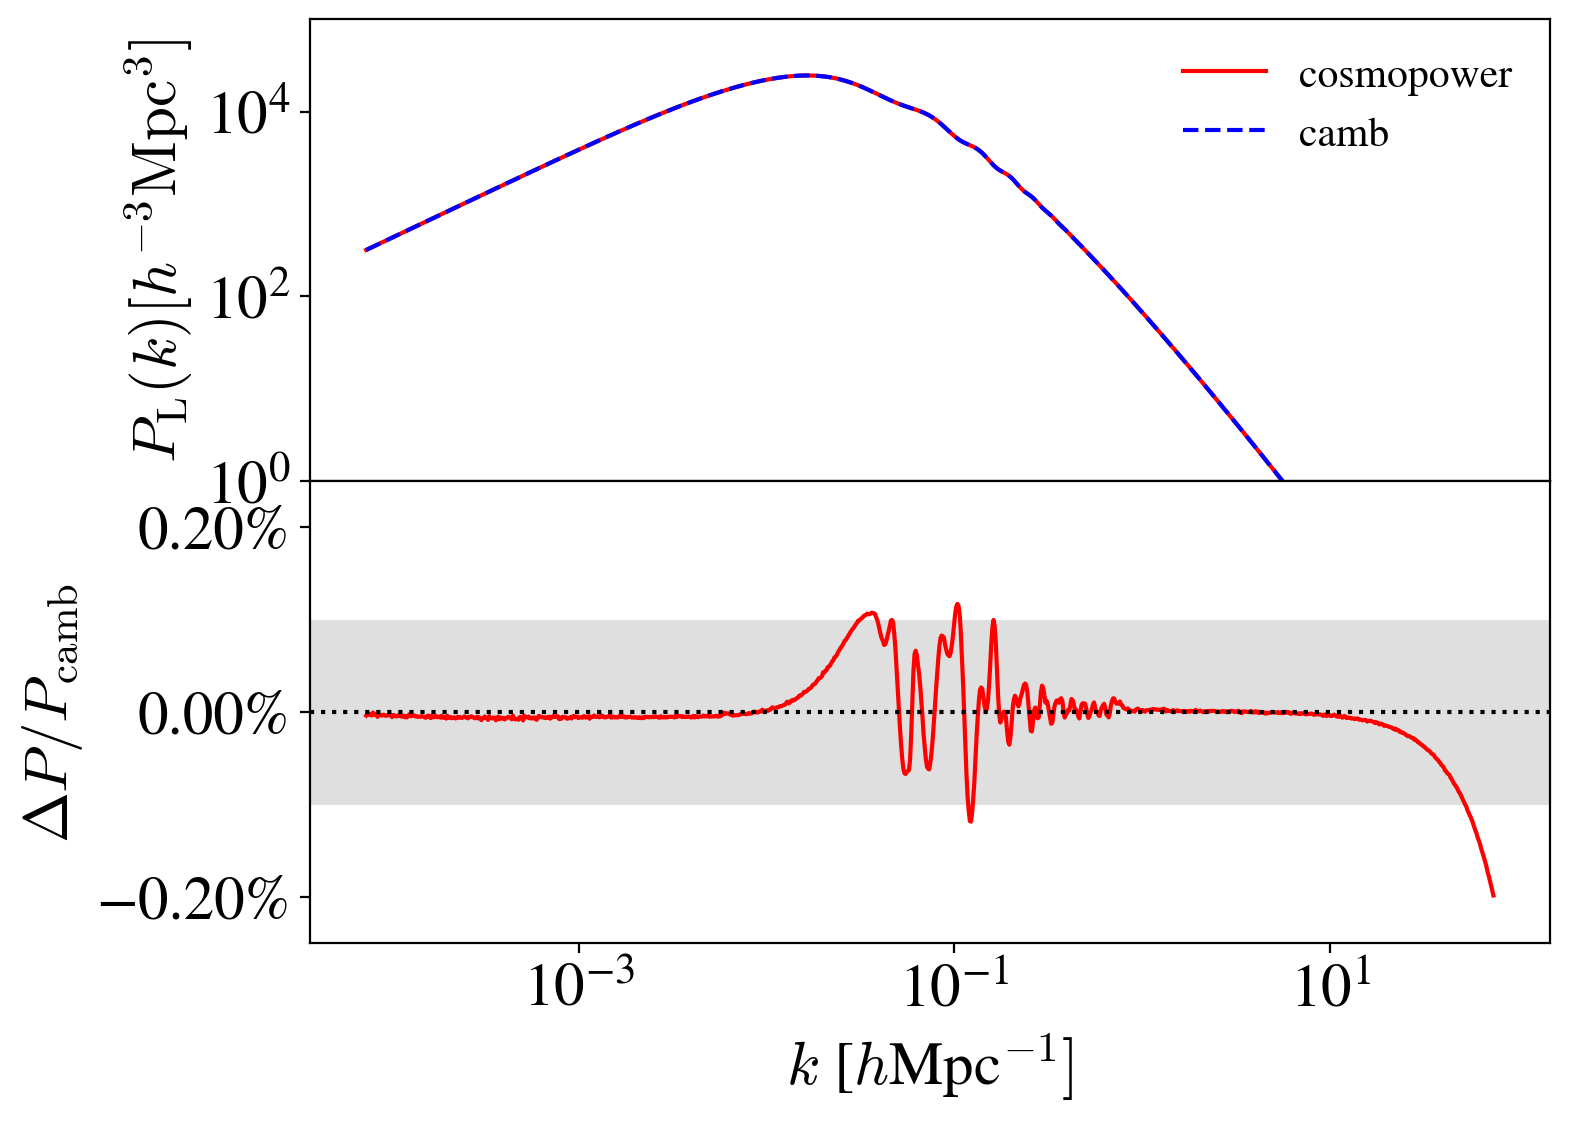

In [380]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,6),sharex=True)
fig.subplots_adjust(hspace=0) 
ax[0].loglog(custom_k/h, cosmopower_pk, 'r', label = 'cosmopower')
ax[0].loglog(custom_k/h, camb_pk(custom_k/h), 'b', ls='--', label = 'camb')
#ax[0].set_xlim(custom_k.min(),custom_k.max())
ax[0].set_ylim(1,1e5)
ax[0].set_ylabel(r'$P_{\mathrm{L}}(k) [h^{-3}\mathrm{Mpc}^3]$')
ax[1].axhspan(-1e-3, 1e-3, facecolor='silver', alpha=0.5,zorder=0)
ax[1].semilogx(custom_k/h,(cosmopower_pk-camb_pk(custom_k/h))/camb_pk(custom_k/h),c='r',zorder=1)
ax[1].axhline(y=0.,c='k',ls=':',zorder=2)
ax[1].set_ylim(-2.5e-3,2.5e-3)
ax[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax[1].set_xlabel(r'$k$ [$h$Mpc$^{-1}]$')
ax[1].set_ylabel(r'$\Delta P/P_{\mathrm{camb}}$')
ax[0].legend(fontsize=15, frameon=False)

## Investigate derivatives of $P_{\mathrm{L}}(k)$ w.r.t. cosmological parameters

In [384]:
# Default model
default_emulator_derivatives = default_emulator.derivative(default_params)
print(default_emulator_derivatives.shape)

# Custom model
custom_emulator_derivatives = custom_emulator.derivative(custom_params)
print(custom_emulator_derivatives.shape)

(420, 6, 1)
(1000, 9, 1)


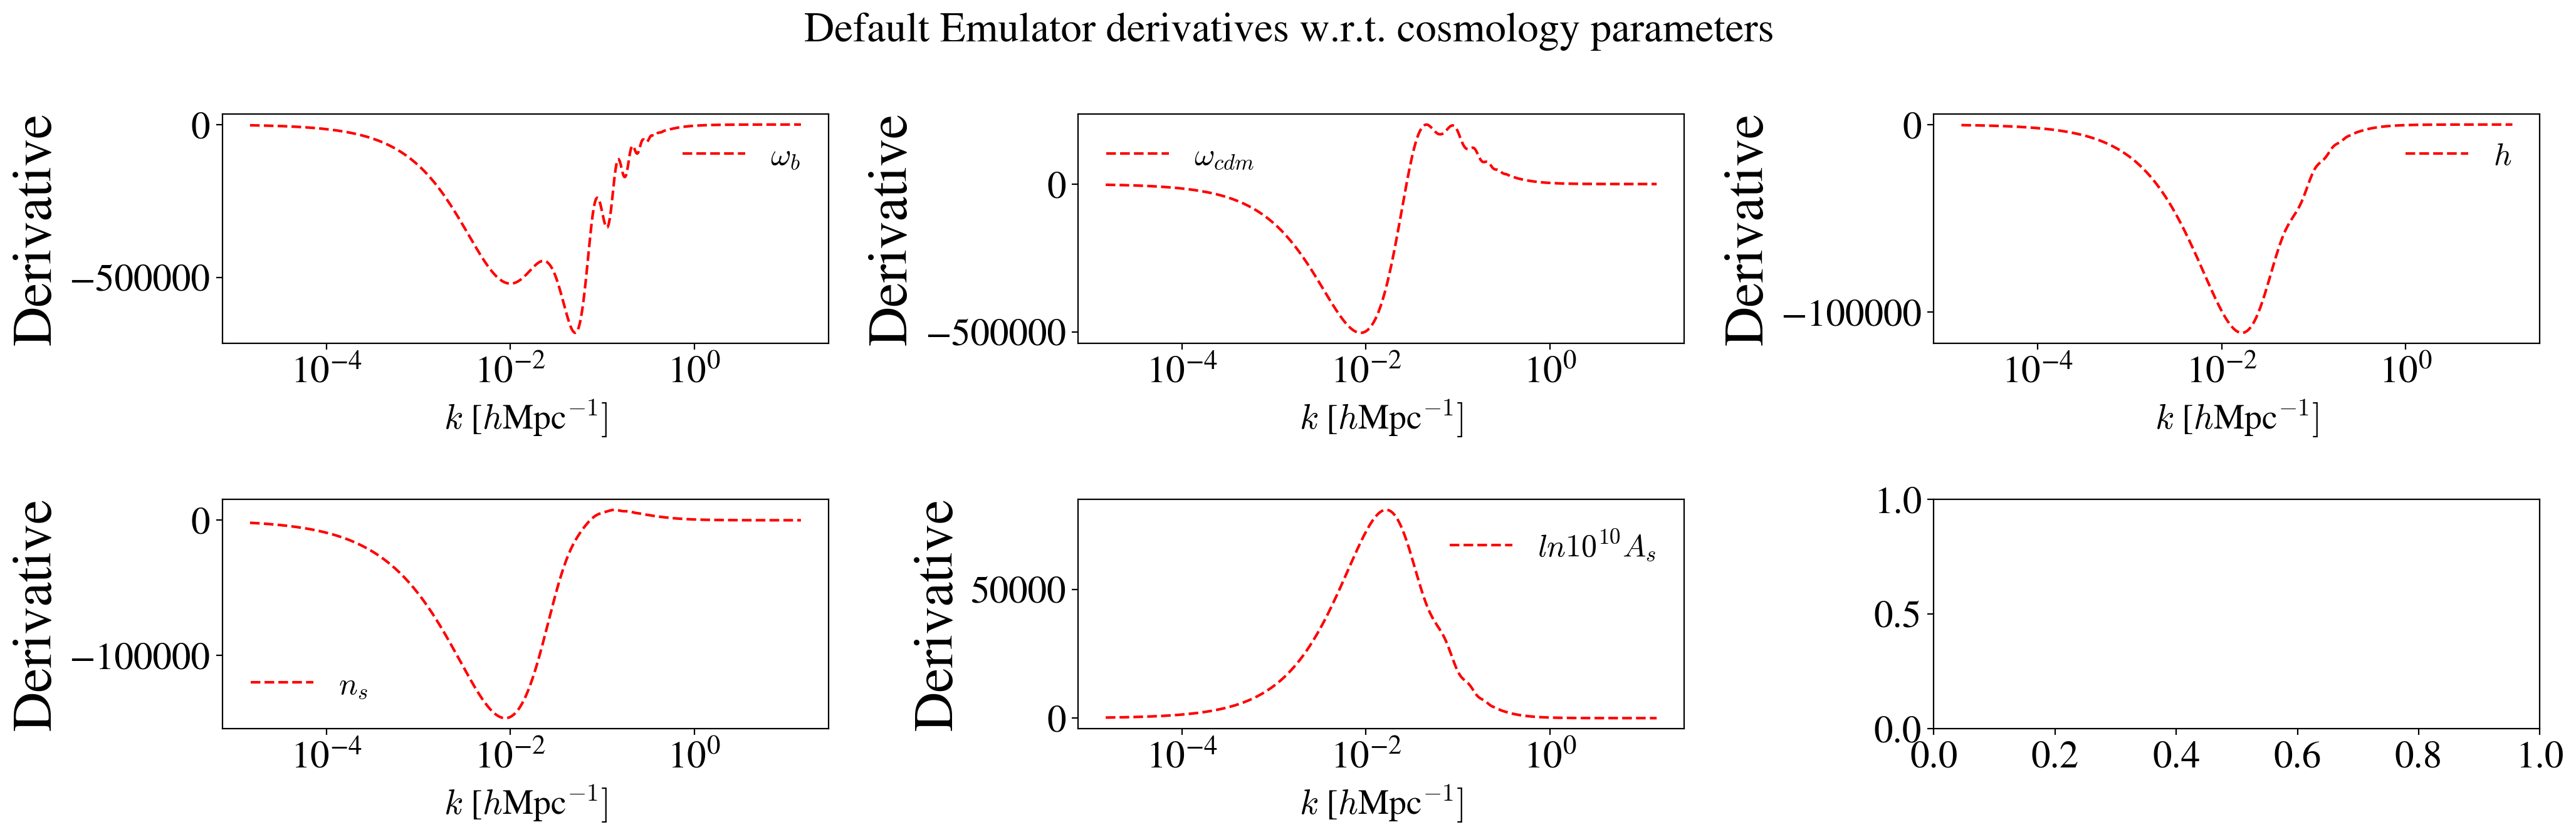

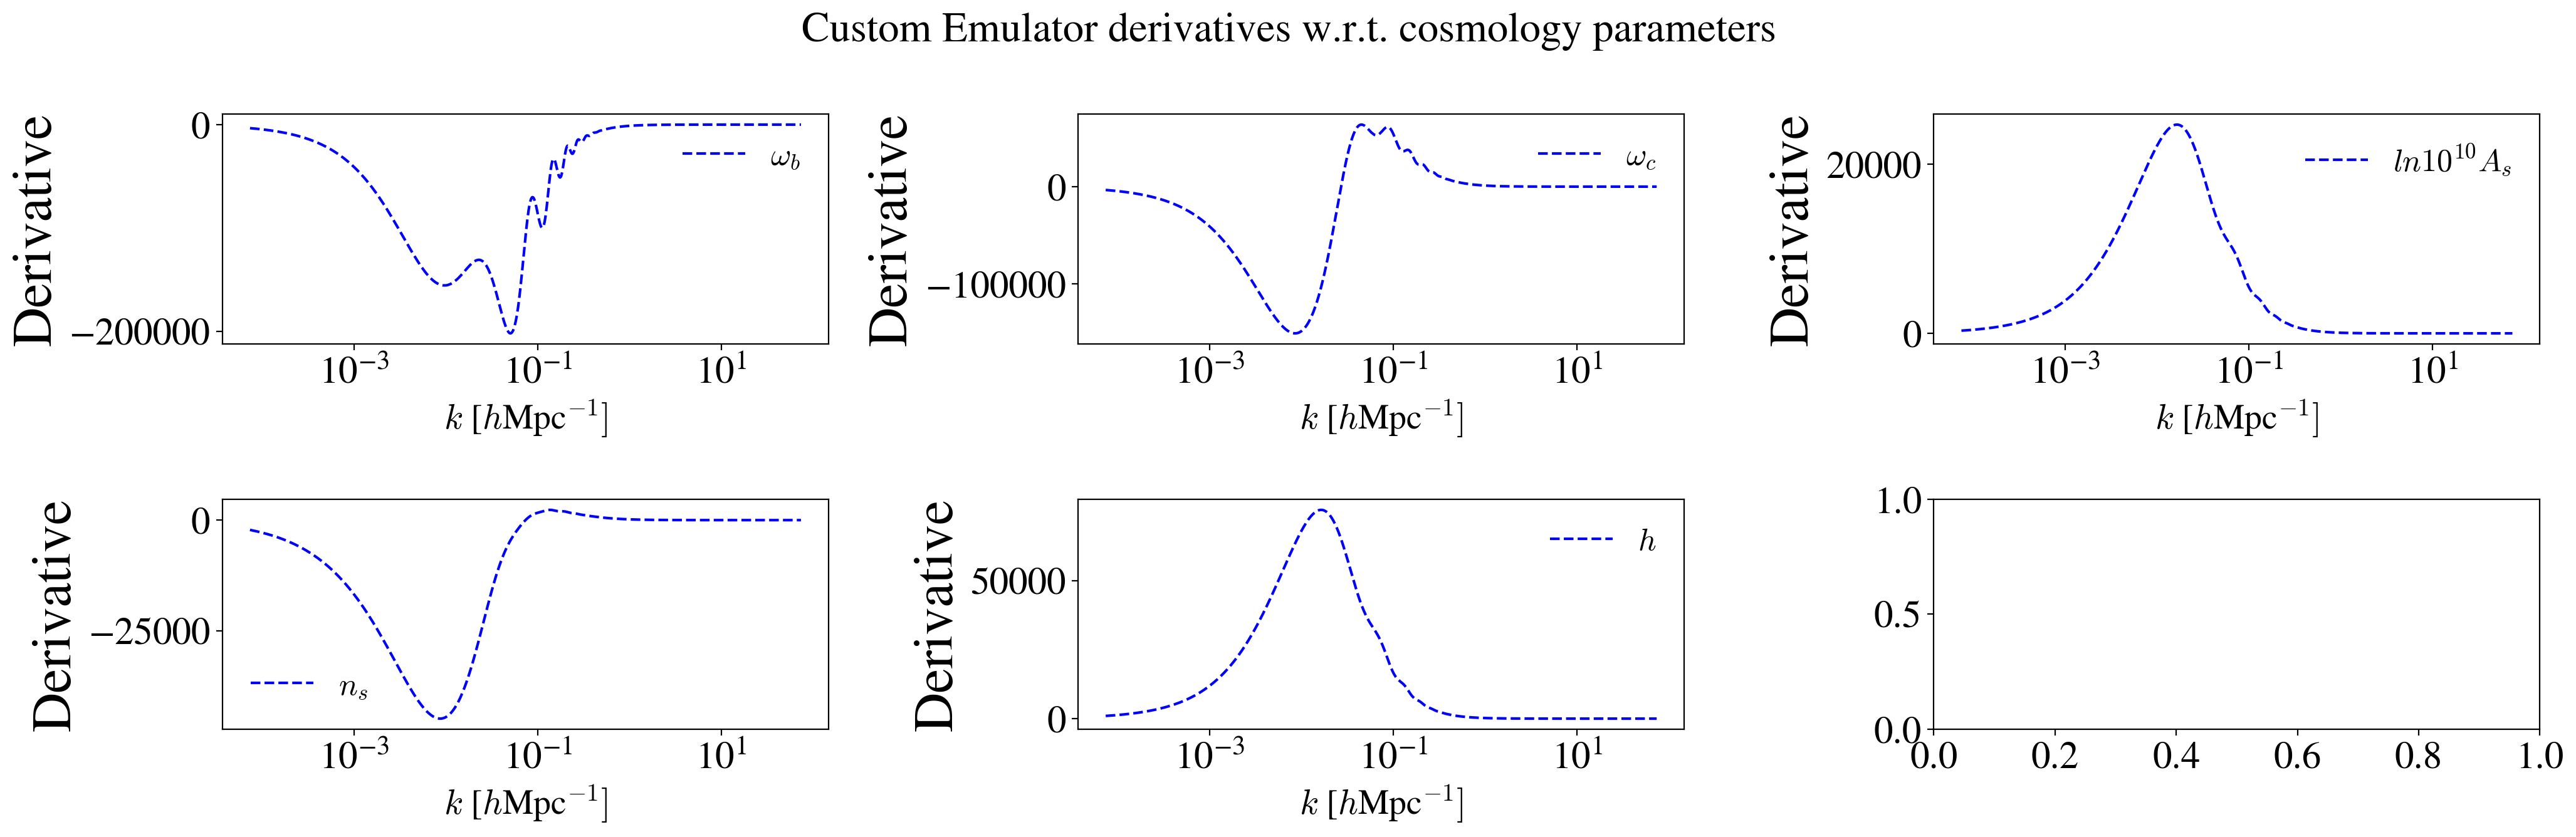

In [409]:
default_parameters = [r'$\omega_b$', r'$\omega_{cdm}$', r'$h$', r'$n_s$', r'$ln10^{10}A_s$']
custom_parameters = [r'$\omega_b$', r'$\omega_c$',r'$ln10^{10}A_s$', r'$n_s$', r'$h$']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(21,7))
for i, ax in enumerate(axes.flatten()):
    if i==len(default_parameters):
        break
    default_deriv = default_emulator_derivatives[:, i, 8]
    ax.semilogx(default_k/h, default_deriv, c='r', label = default_parameters[i], linestyle='--')
    ax.set_xlabel('$k$ [$h$Mpc$^{-1}]$', fontsize=20)
    ax.set_ylabel('Derivative', fontsize='x-large')
    ax.legend(fontsize=18, frameon=False)
fig.suptitle("Default Emulator derivatives w.r.t. cosmology parameters", fontsize=24)
plt.tight_layout()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(21,7))
for i, ax in enumerate(axes.flatten()):
    if i==len(custom_parameters):
        break
    custom_deriv = custom_emulator_derivatives[:, i, 8]
    ax.semilogx(custom_k/h, custom_deriv, c='b', label = custom_parameters[i], linestyle='--')
    ax.set_xlabel('$k$ [$h$Mpc$^{-1}]$', fontsize=20)
    ax.set_ylabel('Derivative', fontsize='x-large')
    ax.legend(fontsize=18, frameon=False)
fig.suptitle("Custom Emulator derivatives w.r.t. cosmology parameters", fontsize=24)
plt.tight_layout()